# Neural Style Transfer

In [67]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import random
import cv2
import matplotlib.pyplot as plt

import copy
from scipy import ndimage

## Style transfer

The Neural Style Transfer is an algorithm that takes as input a content-image and a style-image and returns the content of the content-image as if it was ‘painted’ using the artistic style of the style-image.

In [2]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

(719, 990, 3)

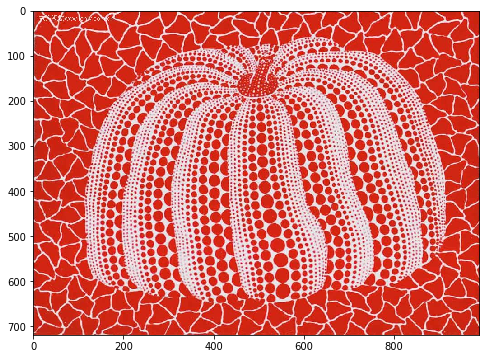

In [3]:
path = "yayo.jpg"
style_img = read_image(path)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(style_img)
style_img.shape

Here is my content image. 

(663, 750, 3)

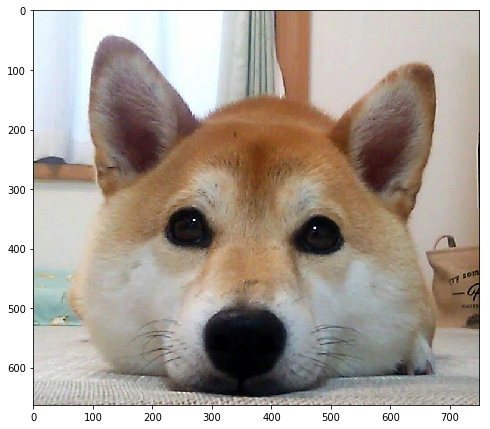

In [4]:
path2 = "shiba.jpg"
content_img = read_image(path2)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(content_img)
content_img.shape

## Preprocessing
We need style and content images of the same size.

In [5]:
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

(300, 300, 3)

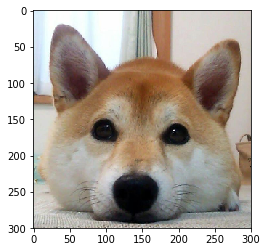

In [6]:
content_img = center_crop(content_img)
content_img = cv2.resize(content_img, (300, 300))
plt.imshow(content_img)
content_img.shape

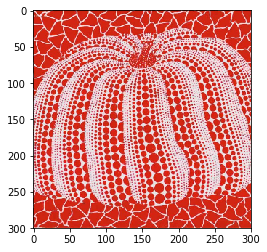

In [7]:
style_img = center_crop(style_img)
style_img = cv2.resize(style_img, (300, 300))
style_img.shape
plt.imshow(style_img)

In [8]:
def transform_images(im):
    """ Transform images to be ready for vgg"""
    im = np.rollaxis(im, 2)
    im = im[None]
    return torch.tensor(im, dtype=torch.float32).cuda()

In [10]:
style_img = transform_images(style_img/255)
content_img = transform_images(content_img/255)

In [11]:
style_img.shape

torch.Size([1, 3, 300, 300])

## Prepare model

In [12]:
inception = models.inception_v3(pretrained=True).cuda().eval()

In [14]:
for name, layer in inception._modules.items():
    print (name)

Conv2d_1a_3x3
Conv2d_2a_3x3
Conv2d_2b_3x3
Conv2d_3b_1x1
Conv2d_4a_3x3
Mixed_5b
Mixed_5c
Mixed_5d
Mixed_6a
Mixed_6b
Mixed_6c
Mixed_6d
Mixed_6e
AuxLogits
Mixed_7a
Mixed_7b
Mixed_7c
fc


In [22]:
inception = models.inception_v3(True).eval()

In [19]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [20]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size() 
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t()) 
        return G.div(a * b * c * d)

In [21]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [41]:
content_layers = ['Mixed_5b']
style_layers = ['Conv2d_4a_3x3', 'Mixed_5b', 'Mixed_6a', 'Mixed_7a']

In [44]:
def get_style_model_and_losses(cnn, style_img, content_img, style_weight, content_weight, 
                               content_layers=content_layers,style_layers=style_layers):
    cnn = copy.deepcopy(cnn)
    cnn = cnn.cuda()
        
    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    model = nn.Sequential()#.cuda() # the new Sequential module network
    gram = GramMatrix()#.cuda() # we need a gram module in order to compute style targets

    model = model.cuda()
    gram = gram.cuda()


    for name, layer in cnn._modules.items():
        if name not in ['AuxLogits','fc']:
            model.add_module(name,layer)
        
        if name in content_layers:
            #print (name)
            target = model(content_img).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + name, content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:   
            #print (name)
            target_feature = model(style_img).clone()
            target_feature_gram = gram(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + name, style_loss)
            style_losses.append(style_loss)

    return model, style_losses, content_losses

In [35]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [36]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps, style_weight, content_weight):
    
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    
    optimizer = get_input_optimizer(input_img)
    
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [34]:
input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size()).cuda()

In [79]:
output = run_style_transfer(inception, content_img, style_img, input_img, num_steps=100, style_weight=1000, content_weight=10)

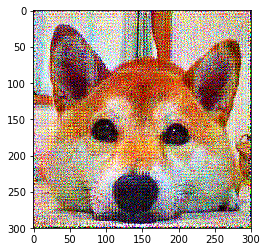

In [80]:
output_data = output.data
output_data = output_data.cpu()
output_data = output_data.view(3, 300, 300)
unloader = transforms.ToPILImage()
output_data = unloader(output_data)
plt.imshow(output_data)
plt.ioff()
plt.show()

In [81]:
output = run_style_transfer(inception, content_img, style_img, input_img, num_steps=100, style_weight=10000, content_weight=1)

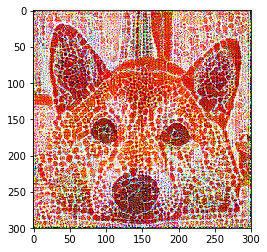

In [82]:
output_data = output.data
output_data = output_data.cpu()
output_data = output_data.view(3, 300, 300)
unloader = transforms.ToPILImage()
output_data = unloader(output_data)
plt.imshow(output_data)
plt.ioff()
plt.show()

In [83]:
content_layers = ['Mixed_5b', 'Mixed_5d']
style_layers = ['Conv2d_4a_3x3', 'Mixed_5b', 'Mixed_6a', 'Mixed_6e']

In [84]:
output = run_style_transfer(inception, content_img, style_img, input_img, num_steps=100, style_weight=1000, content_weight=10)

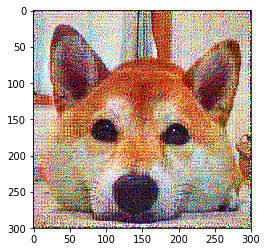

In [85]:
output_data = output.data
output_data = output_data.cpu()
output_data = output_data.view(3, 300, 300)
unloader = transforms.ToPILImage()
output_data = unloader(output_data)
plt.imshow(output_data)
plt.ioff()
plt.show()